# Preparation

In [0]:
! wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip
! unzip wikitext-103-v1.zip

In [0]:
! wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
! unzip wikitext-2-v1.zip

In [0]:
import numpy as np
import os
from tqdm import tqdm
import string
import tensorflow as tf
import re
import matplotlib.pyplot as plt
tf.enable_eager_execution()

# Implement the language model

In [0]:
class Language_model:

    def __init__(self, folder_path):
       
       self.folder_path = folder_path
       
    def get_text(self, file_name):
        
        path = os.path.join(self.folder_path, file_name)
        with open(path, 'r', encoding='utf-8') as f:
            document = []
            for sentence in tqdm(f, desc=f'PROCESSING {file_name}', position=0):

                if len(sentence)>2:                                                       # preprocess and add the cut-off (end of string) token
                    accepted_char = '[a-zA-z=.<>]+'
                    sentence = ' '.join(re.findall(accepted_char, sentence)).strip()
                    if not sentence.endswith('='):
                        sentence += '\x00'
                    document.append(sentence.lower())
        return '\n'.join(document).strip()

    
    def encode_data(self, seq_length=300):

        self.train = self.get_text('wiki.train.tokens') 
        self.valid = self.get_text('wiki.valid.tokens') 
        self.test = self.get_text('wiki.test.tokens')
        print('-'*100)
        print('ENCODING_DATA ...')
        self.vocab = sorted(set(self.train))
        print ('Vocabulary has: {} unique characters'.format(len(self.vocab)))

        self.char2idx = {u:i for i, u in enumerate(self.vocab)}
        self.idx2char = np.array(self.vocab)

        encoded_train = np.array([self.char2idx[c] for c in self.train])
        encoded_valid = np.array([self.char2idx[c] for c in self.valid])
        encoded_test = np.array([self.char2idx[c] for c in self.test])

        train_dataset = tf.data.Dataset.from_tensor_slices(encoded_train)
        valid_dataset = tf.data.Dataset.from_tensor_slices(encoded_valid)
        test_dataset = tf.data.Dataset.from_tensor_slices(encoded_test)

        self.train_sequences = train_dataset.batch(seq_length+1, drop_remainder=True)
        self.valid_sequences = valid_dataset.batch(seq_length+1, drop_remainder=True)
        self.test_sequences = test_dataset.batch(seq_length+1, drop_remainder=True)

    def generate_data(self, BATCH_SIZE=64):

        self.encode_data()
        print('-'*100)
        print('GENERATING DATA ...')
        def split_input_target(chunk):
            input_text = chunk[:-1]
            target_text = chunk[1:]
            return input_text, target_text

        train_dataset = self.train_sequences.map(split_input_target)
        valid_dataset = self.valid_sequences.map(split_input_target)
        test_dataset = self.test_sequences.map(split_input_target)

        self.train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
        self.valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
        self.test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

    def build_model(self, embedding_dim=256, rnn_units=1024, batch_size=64, rnn_type='RNN'):
        
        assert rnn_type in ['RNN', 'LSTM', 'GRU'], 'Invalid RNN architecture!'
        
        self.embedding_dim = embedding_dim
        self.rnn_units = rnn_units
        self.batch_size = batch_size
        self.rnn_type = rnn_type

        print('-'*90)
        if  self.rnn_type == 'LSTM':  

            self.model = tf.keras.Sequential([
                    tf.keras.layers.Embedding(len(self.vocab), embedding_dim,
                                              batch_input_shape=[batch_size, None]),
                    tf.keras.layers.LSTM(rnn_units,
                                         stateful=True,
                                         return_sequences=True), 
                    tf.keras.layers.Dropout(0.2),                                
                    tf.keras.layers.Dense(len(self.vocab))
                    ])
            
        elif self.rnn_type == 'RNN':

            self.model = tf.keras.Sequential([
                    tf.keras.layers.Embedding(len(self.vocab), embedding_dim,
                                              batch_input_shape=[batch_size, None]),           
                    tf.keras.layers.SimpleRNN(rnn_units,
                                         stateful=True,
                                         return_sequences=True), 
                    tf.keras.layers.Dropout(0.2),                                
                    tf.keras.layers.Dense(len(self.vocab))
                    ])  
        else:

            self.model = tf.keras.Sequential([
                    tf.keras.layers.Embedding(len(self.vocab), embedding_dim,
                                              batch_input_shape=[batch_size, None]),
                    tf.keras.layers.GRU(rnn_units,
                                         stateful=True,
                                         return_sequences=True), 
                    tf.keras.layers.Dropout(0.2),                                
                    tf.keras.layers.Dense(len(self.vocab))
                    ])  

        print(self.model.summary())
        return self.model
    
    def train_model(self, checkpoint_dir = './training_checkpoints', EPOCHS=10):
        
        self.checkpoint_dir = checkpoint_dir
        def loss(labels, logits):
            return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    
        def accuracy(labels, logits):
            return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)

        self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=[accuracy])
        self.checkpoint_dir = './training_checkpoints'
        checkpoint_prefix = os.path.join(self.checkpoint_dir, '{val_accuracy}')

        checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_prefix,
            save_weights_only=True)
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
       
        self.history = self.model.fit(self.train_dataset, 
                                      epochs=EPOCHS, 
                                      validation_data=self.valid_dataset,
                                      callbacks=[checkpoint_callback, early_stopping])
        
        
    def plot_history(self):

        print('EVALUATING ON TEST SET')
        self.model.evaluate(self.test_dataset, verbose=1)
        print('-'*100)
        fig, ax = plt.subplots(1,2, figsize=(16, 6))
        plt.subplot(1,2,1)
        plt.plot(self.history.history['loss'], label='Train')
        plt.plot(self.history.history['val_loss'], label='Validataion')
        plt.title('Loss on training and validation sets')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc="upper right")
        plt.subplot(1,2,2)
        plt.plot(self.history.history['accuracy'], label='Train')
        plt.plot(self.history.history['val_accuracy'], label='Validataion')
        plt.title('Accuracy on training and validation sets')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc="upper left")                
        plt.show()

    def generate_text(self, string, max_chars=300):

        best_model = self.build_model(self.embedding_dim, self.rnn_units, batch_size=1, rnn_type=self.rnn_type)    # load pretrained model and change batch size for prediction
        best_model.load_weights(tf.train.latest_checkpoint(self.checkpoint_dir))
        best_model.build(tf.TensorShape([1, None]))
        
        input_seq = [self.char2idx[c] for c in string]
        input_seq = tf.expand_dims(input_seq, 0)
        text_generated = []

        temperature = 1                    # the higher temperature, the more surprising text
        best_model.reset_states()    
            
        for i in range(max_chars):                      # decode until the model produce the '\x00' character or when reaching time fixed time step (defaut=300)
            next_char = best_model(input_seq)
            next_char = tf.squeeze(next_char, 0) / temperature
            next_char_id = tf.random.categorical(next_char, num_samples=1)[-1, 0].numpy()
            input_seq = tf.expand_dims([next_char_id], 0)
            predicted_char = self.idx2char[next_char_id]
            if predicted_char == '\x00':
                break
            text_generated.append(predicted_char)
  
        return string + ''.join(text_generated)

In [0]:
wiki103_folder = os.path.join(os.getcwd(), 'wikitext-103')

wiki103_paths = [os.path.join(wiki103_folder, file_name) for file_name in os.listdir(wiki103_folder)]
wiki103_paths

['/content/drive/My Drive/Cinnamon/a7/wikitext-103/wiki.train.tokens',
 '/content/drive/My Drive/Cinnamon/a7/wikitext-103/wiki.test.tokens',
 '/content/drive/My Drive/Cinnamon/a7/wikitext-103/wiki.valid.tokens']

In [0]:
wiki2_folder = os.path.join(os.getcwd(), 'wikitext-2')

wiki2_paths = [os.path.join(wiki2_folder, file_name) for file_name in os.listdir(wiki2_folder)]
wiki2_paths

['/content/drive/My Drive/Cinnamon/a7/wikitext-2/wiki.train.tokens',
 '/content/drive/My Drive/Cinnamon/a7/wikitext-2/wiki.valid.tokens',
 '/content/drive/My Drive/Cinnamon/a7/wikitext-2/wiki.test.tokens']

I will take the wiki 2 data because of my limited computation resource

In [0]:
%%time
LM = Language_model(wiki2_folder)
LM.generate_data()

PROCESSING wiki.train.tokens: 36718it [00:00, 74494.19it/s]
PROCESSING wiki.valid.tokens: 3760it [00:00, 66672.80it/s]
PROCESSING wiki.test.tokens: 4358it [00:00, 78524.17it/s]


----------------------------------------------------------------------------------------------------
ENCODING_DATA ...
Vocabulary has: 38 unique characters
----------------------------------------------------------------------------------------------------
GENERATING DATA ...
CPU times: user 2.36 s, sys: 26.3 ms, total: 2.38 s
Wall time: 2.42 s


In [0]:
print(LM.test[1500:1800])

unk> starred in the film <unk> directed by paris <unk> . 
= = career = =
= = = = = =
in <unk> had a guest starring role on the television series the bill he portrayed scott parry in the episode in safe hands . <unk> starred as scott in the play herons written by simon stephens which was performed in


## Traditional RNN

In [0]:
LM.build_model(rnn_type='RNN')

------------------------------------------------------------------------------------------
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (64, None, 256)           9728      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (64, None, 1024)          1311744   
_________________________________________________________________
dropout_7 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
dense_7 (Dense)              (64, None, 38)            38950     
Total params: 1,360,422
Trainable params: 1,360,422
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
LM.train_model(EPOCHS=5)

Epoch 1/5
521/521 [==============================] - 114s 219ms/step - loss: 2.2290 - accuracy: 0.3503 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
521/521 [==============================] - 113s 217ms/step - loss: 1.7916 - accuracy: 0.4669 - val_loss: 1.5368 - val_accuracy: 0.5408
Epoch 3/5
521/521 [==============================] - 113s 216ms/step - loss: 1.6159 - accuracy: 0.5205 - val_loss: 1.4231 - val_accuracy: 0.5722
Epoch 4/5
521/521 [==============================] - 115s 220ms/step - loss: 1.5269 - accuracy: 0.5458 - val_loss: 1.3628 - val_accuracy: 0.5895
Epoch 5/5
521/521 [==============================] - 115s 220ms/step - loss: 1.4720 - accuracy: 0.5609 - val_loss: 1.3252 - val_accuracy: 0.5999
CPU times: user 13min 33s, sys: 45.6 s, total: 14min 19s
Wall time: 9min 28s


EVALUATING ON TEST SET
60/60 [==============================] - 3s 42ms/step - loss: 1.3204 - accuracy: 0.6019
----------------------------------------------------------------------------------------------------


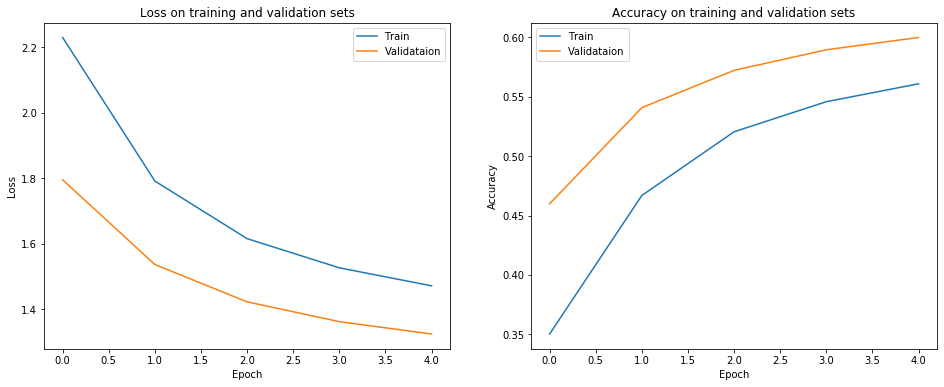

In [0]:
LM.plot_history()

In [0]:
LM.generate_text('an invasion of europe in would be') # a small text on the test set

------------------------------------------------------------------------------------------
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (1, None, 256)            9728      
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (1, None, 1024)           1311744   
_________________________________________________________________
dropout_15 (Dropout)         (1, None, 1024)           0         
_________________________________________________________________
dense_15 (Dense)             (1, None, 38)             38950     
Total params: 1,360,422
Trainable params: 1,360,422
Non-trainable params: 0
_________________________________________________________________
None


'an invasion of europe in would be alone had an home and did him as rusn moviate played tower making her <unk> specuro unines they plop stan and people of bratil on m appears in flie participer and speriophonisted and monemellisted for the ymost of heavier <unk> .\n= = cround planna voowing on a form of morking . men as a form largi'

## GRU

In [0]:
LM.build_model(rnn_type='GRU')

------------------------------------------------------------------------------------------
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (64, None, 256)           9728      
_________________________________________________________________
gru_4 (GRU)                  (64, None, 1024)          3935232   
_________________________________________________________________
dropout_17 (Dropout)         (64, None, 1024)          0         
_________________________________________________________________
dense_17 (Dense)             (64, None, 38)            38950     
Total params: 3,983,910
Trainable params: 3,983,910
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
LM.train_model(EPOCHS=5)

Epoch 1/5
521/521 [==============================] - 316s 606ms/step - loss: 2.0910 - accuracy: 0.3896 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
521/521 [==============================] - 314s 602ms/step - loss: 1.5818 - accuracy: 0.5265 - val_loss: 1.3627 - val_accuracy: 0.5878
Epoch 3/5
521/521 [==============================] - 314s 602ms/step - loss: 1.4209 - accuracy: 0.5708 - val_loss: 1.2729 - val_accuracy: 0.6121
Epoch 4/5
521/521 [==============================] - 314s 603ms/step - loss: 1.3381 - accuracy: 0.5937 - val_loss: 1.2262 - val_accuracy: 0.6250
Epoch 5/5
521/521 [==============================] - 315s 605ms/step - loss: 1.2856 - accuracy: 0.6083 - val_loss: 1.1980 - val_accuracy: 0.6326
CPU times: user 30min 38s, sys: 1min 44s, total: 32min 23s
Wall time: 26min 12s


## LSTM

In [0]:
LM.build_model(rnn_type='LSTM')

------------------------------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           9728      
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dropout_2 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
dense_2 (Dense)              (64, None, 38)            38950     
Total params: 5,295,654
Trainable params: 5,295,654
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
LM.train_model(EPOCHS=5)

Epoch 1/5
521/521 [==============================] - 408s 783ms/step - loss: 2.1216 - accuracy: 0.3760 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
521/521 [==============================] - 406s 780ms/step - loss: 1.5790 - accuracy: 0.5258 - val_loss: 1.3466 - val_accuracy: 0.5914
Epoch 3/5
521/521 [==============================] - 405s 777ms/step - loss: 1.4009 - accuracy: 0.5750 - val_loss: 1.2461 - val_accuracy: 0.6179
Epoch 4/5
521/521 [==============================] - 404s 776ms/step - loss: 1.3158 - accuracy: 0.5983 - val_loss: 1.1979 - val_accuracy: 0.6305
Epoch 5/5
521/521 [==============================] - 408s 782ms/step - loss: 1.2631 - accuracy: 0.6128 - val_loss: 1.1687 - val_accuracy: 0.6386
CPU times: user 38min 40s, sys: 3min 12s, total: 41min 52s
Wall time: 33min 50s
